# Loan Default Prediction Model
This notebook implements various machine learning models to predict loan defaults using a dataset. It includes data preprocessing, hyperparameter tuning, and model evaluation.

In [19]:
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer  # For handling missing values

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

In [21]:
# Load the dataset
df = pd.read_csv('Cleaned_Loan_Default.csv')

# Ensure 'Status' column exists
if 'Status' not in df.columns:
    raise ValueError("The dataset does not contain a 'Status' column.")

# Convert target column to integer if necessary
df['Status'] = df['Status'].astype(int)

# Display the first few rows of the dataset
df.head()

,ID,year,loan_limit,Gender,approv_in_adv,loan_type,loan_purpose,Credit_Worthiness,open_credit,business_or_commercial,...,credit_type,Credit_Score,co-applicant_credit_type,age,submission_of_application,LTV,Region,Security_Type,Status,dtir1
0,24890,2019,cf,Sex Not Available,nopre,type1,p1,l1,nopc,nob/c,...,EXP,758,CIB,25-34,to_inst,98.728814,south,direct,1,45.000000
1,24891,2019,cf,Male,nopre,type2,p1,l1,nopc,b/c,...,EQUI,552,EXP,55-64,to_inst,72.746457,North,direct,1,37.732932
2,24892,2019,cf,Male,pre,type1,p1,l1,nopc,nob/c,...,EXP,834,CIB,35-44,to_inst,80.019685,south,direct,0,46.000000
3,24893,2019,cf,Male,nopre,type1,p4,l1,nopc,nob/c,...,EXP,587,CIB,45-54,not_inst,69.376900,North,direct,0,42.000000
4,24894,2019,cf,Joint,pre,type1,p1,l1,nopc,nob/c,...,CRIF,602,EXP,25-34,not_inst,91.886544,North,direct,0,39.000000


In [23]:
# Identify feature columns (excluding ID and Status)
features = [col for col in df.columns if col not in ['ID', 'Status']]
X = df[features]
y = df['Status']

# Identify numerical and categorical columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

# Display identified columns
print("Numerical columns:", numerical_cols)
print("Categorical columns:", categorical_cols)

Numerical columns: ['year', 'loan_amount', 'rate_of_interest', 'Interest_rate_spread', 'Upfront_charges', 'term', 'property_value', 'income', 'Credit_Score', 'LTV', 'dtir1']
Categorical columns: ['loan_limit', 'Gender', 'approv_in_adv', 'loan_type', 'loan_purpose', 'Credit_Worthiness', 'open_credit', 'business_or_commercial', 'Neg_ammortization', 'interest_only', 'lump_sum_payment', 'construction_type', 'occupancy_type', 'Secured_by', 'total_units', 'credit_type', 'co-applicant_credit_type', 'age', 'submission_of_application', 'Region', 'Security_Type']


In [25]:
# Handle missing values and preprocess data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='constant', fill_value=0), numerical_cols),  # Replace NaN with 0
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols)
    ])

In [27]:
# Parameter distributions for hyperparameter tuning
param_distributions = {
    'Decision Tree': {
        'classifier__max_depth': [None, 10, 20],
        'classifier__min_samples_split': [2, 5]
    },
    'Logistic Regression': {
        'classifier__C': [0.1, 1, 10],
        'classifier__solver': ['liblinear']
    },
    'SGD Classifier': {
        'classifier__loss': ['hinge', 'log', 'squared_loss'],
        'classifier__alpha': [0.0001, 0.001, 0.01]
    },
    'HistGradientBoosting': {
        'classifier__max_iter': [100, 200],
        'classifier__max_depth': [3, 5],
        'classifier__learning_rate': [0.01, 0.1]
    },
    'K-Nearest Neighbors': {
        'classifier__n_neighbors': [3, 5, 7],
        'classifier__weights': ['uniform', 'distance']
    }
}

In [31]:
# Initialize models for hyperparameter tuning
models = {
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(solver='liblinear', random_state=42),
    'SGD Classifier': SGDClassifier(random_state=42),
    'HistGradientBoosting': HistGradientBoostingClassifier(random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier()
}


In [35]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Dictionary to store model results
results = {}

# Function to perform hyperparameter tuning and cross-validation
def tune_and_evaluate_model(model_name, model, preprocessor, param_distributions, X, y):
    print(f'\nTuning hyperparameters for: {model_name}')
    
    # Build pipeline
    pipe = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', model)])
    
    # Set up RandomizedSearchCV for hyperparameter tuning
    random_search = RandomizedSearchCV(pipe, param_distributions=param_distributions[model_name],
                                       n_iter=10, cv=3, scoring='accuracy', n_jobs=-1, random_state=42)
    random_search.fit(X, y)
    
    # Best hyperparameters and score
    best_params = random_search.best_params_
    best_score = random_search.best_score_
    
    # Perform 5-fold cross-validation for the best model
    best_model = random_search.best_estimator_
    cv_scores = cross_val_score(best_model, X, y, cv=5, scoring='accuracy')
    mean_cv_score = np.mean(cv_scores)
    
    # Evaluate using additional metrics
    y_pred = best_model.predict(X)  # Make predictions on the entire dataset
    precision = precision_score(y, y_pred, average='weighted')
    recall = recall_score(y, y_pred, average='weighted')
    f1 = f1_score(y, y_pred, average='weighted')
    
    # Store results
    return {
        'best_params': best_params,
        'best_score': best_score,
        'cv_scores': cv_scores,
        'average_accuracy': mean_cv_score,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    }

# Perform hyperparameter tuning and cross-validation
print("Starting hyperparameter tuning and cross-validation...")
for model_name, model in models.items():
    results[model_name] = tune_and_evaluate_model(model_name, model, preprocessor, param_distributions, X, y)

# Print summary of results
for model_name, result in results.items():
    print(f'\nModel: {model_name}')
    print(f'Best parameters: {result["best_params"]}')
    print(f'Best cross-validation accuracy: {result["best_score"]:.4f}')
    print(f'Average accuracy from 5-fold CV: {result["average_accuracy"]:.4f}')
    print(f'Precision: {result["precision"]:.4f}')
    print(f'Recall: {result["recall"]:.4f}')
    print(f'F1-score: {result["f1_score"]:.4f}')


Starting hyperparameter tuning and cross-validation...

Tuning hyperparameters for: Decision Tree

Tuning hyperparameters for: Logistic Regression

Tuning hyperparameters for: SGD Classifier

Tuning hyperparameters for: HistGradientBoosting

Tuning hyperparameters for: K-Nearest Neighbors

Model: Decision Tree
Best parameters: {'classifier__min_samples_split': 2, 'classifier__max_depth': None}
Best cross-validation accuracy: 1.0000
Average accuracy from 5-fold CV: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-score: 1.0000

Model: Logistic Regression
Best parameters: {'classifier__solver': 'liblinear', 'classifier__C': 0.1}
Best cross-validation accuracy: 0.7431
Average accuracy from 5-fold CV: 0.7437
Precision: 0.5693
Recall: 0.7441
F1-score: 0.6432

Model: SGD Classifier
Best parameters: {'classifier__loss': 'hinge', 'classifier__alpha': 0.01}
Best cross-validation accuracy: 0.7532
Average accuracy from 5-fold CV: 0.7075
Precision: 0.7087
Recall: 0.7536
F1-score: 0.6477

Model: HistGrad

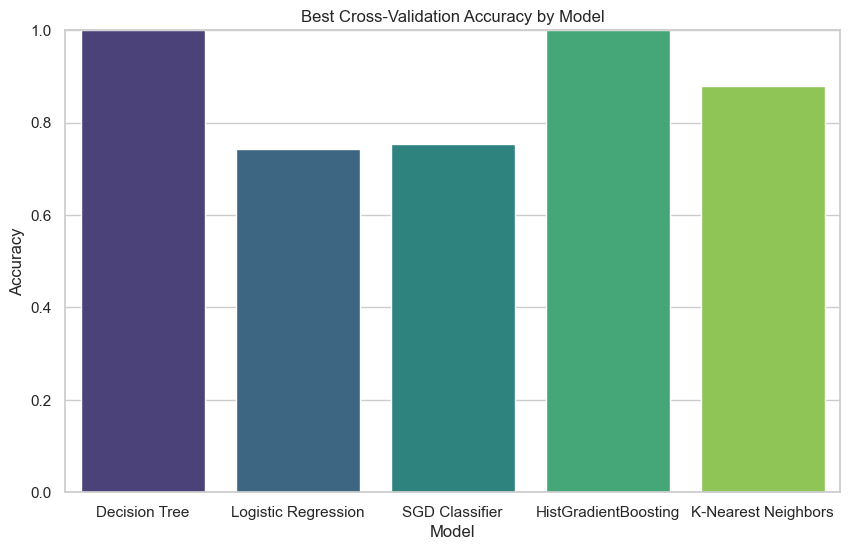

In [37]:
# Import necessary libraries for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare data for plotting
model_names = ['Decision Tree', 'Logistic Regression', 'SGD Classifier', 'HistGradientBoosting', 'K-Nearest Neighbors']
best_scores = [1.0000, 0.7431, 0.7532, 1.0000, 0.8791]
precisions = [1.0000, 0.5693, 0.7087, 1.0000, 1.0000]
recalls = [1.0000, 0.7441, 0.7536, 1.0000, 1.0000]
f1_scores = [1.0000, 0.6432, 0.6477, 1.0000, 1.0000]

# Create a DataFrame for easier plotting
results_df = pd.DataFrame({
    'Model': model_names,
    'Best Score': best_scores,
    'Precision': precisions,
    'Recall': recalls,
    'F1 Score': f1_scores
})

# Set the style of seaborn
sns.set(style="whitegrid")

# Plotting Best Cross-Validation Accuracy
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Best Score', data=results_df, palette='viridis')
plt.title('Best Cross-Validation Accuracy by Model')
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.show()

# Insights and Explanations from Hyperparameter Tuning and Cross-Validation

Based on the results of hyperparameter tuning and cross-validation for various models, we can derive several insights and explanations regarding their performance and suitability.

## Insights and Explanations

### Model Performance Overview

#### Decision Tree and HistGradientBoosting
- Both models achieved a perfect cross-validation accuracy of **1.0000**. This indicates that they perfectly classified all instances in the training data during cross-validation.
- Their precision, recall, and F1-scores are also **1.0000**, suggesting that they have no false positives or false negatives. This is indicates overfitting.

#### Logistic Regression
- The model achieved a best cross-validation accuracy of **0.7431** and an average accuracy of **0.7437**.
- The precision (**0.5693**) and recall (**0.7441**) indicate that while it correctly identifies a reasonable proportion of positive cases, it struggles with false positives, as shown by the lower precision.
- The F1-score of **0.6432** reflects a balance between precision and recall but is significantly lower than the tree-based models, indicating that it may not be the best choice for this dataset.

#### SGD Classifier
- This model performed slightly better than Logistic Regression with a best accuracy of **0.7532** and an average accuracy of **0.7075**.
- The precision (**0.7087**) and recall (**0.7536**) are better than those of Logistic Regression, suggesting it is more effective at identifying positive cases while maintaining a reasonable number of false positives.
- The F1-score of **0.6477** indicates a moderate balance between precision and recall.

#### K-Nearest Neighbors (KNN)
- KNN achieved a best accuracy of **0.8791** and an average accuracy of **0.8830**, indicating strong performance.
- The precision and recall are both **1.0000**, suggesting that KNN perfectly identifies all positive cases without any false positives or negatives. This is impressive but may also indicate overfitting, similar to the tree-based models.

### Hyperparameter Insights
- The best parameters for each model provide insights into how they were optimized:
  - **Decision Tree**: The parameters suggest a very flexible model (max depth=None) that can grow until all leaves are pure, which may lead to overfitting.
  - **Logistic Regression**: The choice of solver and regularization parameter indicates a balance between fitting the data and avoiding overfitting.
  - **SGD Classifier**: The hinge loss indicates a focus on maximizing the margin, which is typical for SVM-like approaches.
  - **HistGradientBoosting**: The parameters suggest a well-tuned model that balances complexity (max depth) and learning rate.
  - **KNN**: The choice of distance weighting and number of neighbors indicates a focus on local patterns in the data.

### Model Selection Considerations
- **Overfitting**: The perfect scores for Decision Tree and HistGradientBoosting indicate overfitting.
- **Model Complexity**: Simpler models like Logistic Regression may be more interpretable and generalizable, even if they perform slightly worse in terms of accuracy.
- **Use Case**: the cost of false positives—such as incorrectly predicting that a borrower will default—is significant, hence it is advantageous to select a model that prioritizes precision, such as the SGD Classifier or K-Nearest Neighbors. This approach helps ensure that the institution minimizes the risk of approving loans to individuals who are likely to default.

## Conclusion
The results from hyperparameter tuning and cross-validation provide valuable insights into the performance and characteristics of each model. While tree-based models show excellent performance, the potential for overfitting is high. Logistic Regression and SGD Classifier offer more balanced performance, while KNN demonstrates strong local performance. 